<a href="https://colab.research.google.com/github/pranav168/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_final_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
#Importing all the required packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
!pip install haversine
import haversine as hs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
!pip install catboost
from catboost import CatBoostRegressor

from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import r2_score,accuracy_score  
from sklearn.model_selection import train_test_split  
from xgboost import XGBRegressor
import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
df=pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv') 
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
df.info()                                                                       #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
column_list=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
# final_tally=list(zip(column_list,distinct_features))                                                           #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['trip_duration']:                                                                    #colur red shows the Dependent Variable('trip_duration')
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,id,id_count,vendor_id,vendor_id_count,pickup_datetime,pickup_datetime_count,dropoff_datetime,dropoff_datetime_count,passenger_count,passenger_count_count,pickup_longitude,pickup_longitude_count,pickup_latitude,pickup_latitude_count,dropoff_longitude,dropoff_longitude_count,dropoff_latitude,dropoff_latitude_count,store_and_fwd_flag,store_and_fwd_flag_count,trip_duration,trip_duration_count
0,id1095034,1,2.000000,780302.000000,2016-01-12 18:48:44,5,2016-02-19 19:25:04,5,1,1033540,-73.982201,633,40.774101,414,-73.982330,443,40.774311,269,N,1450599.000000,368,1624
1,id0365926,1,1.000000,678342.000000,2016-06-10 23:17:17,5,2016-05-16 19:40:28,5,2,210318,-73.982140,607,40.774090,411,-73.982094,433,40.774330,263,Y,8045.000000,408,1584
2,id3032611,1,nan,nan,2016-05-07 13:18:07,5,2016-03-03 20:20:32,4,5,78088,-73.982101,587,40.774120,410,-73.982246,430,40.750149,259,nan,nan,348,1582
3,id1141241,1,nan,nan,2016-04-05 18:55:21,5,2016-01-07 08:04:32,4,3,59896,-73.982117,585,40.774109,392,-73.982117,427,40.750118,253,nan,nan,367,1581
4,id0775220,1,nan,nan,2016-03-04 08:07:34,5,2016-02-24 06:57:21,4,6,48333,-73.982224,584,40.774078,390,-73.991379,420,40.750198,250,nan,nan,358,1577
5,id0598696,1,nan,nan,2016-02-09 21:03:38,5,2016-02-18 22:37:05,4,4,28404,-73.982094,575,40.774052,376,-73.982201,419,40.750172,247,nan,nan,399,1573
6,id0427590,1,nan,nan,2016-02-24 08:05:31,4,2016-01-08 12:43:38,4,0,60,-73.982246,558,40.774132,356,-73.982269,414,40.774319,245,nan,nan,418,1570
7,id2837959,1,nan,nan,2016-05-20 09:03:18,4,2016-04-13 21:03:01,4,7,3,-73.982208,551,40.774139,352,-73.991402,406,40.774342,244,nan,nan,417,1568
8,id1032439,1,nan,nan,2016-01-06 21:43:57,4,2016-02-29 10:59:06,4,8,1,-73.982307,546,40.774071,347,-73.982384,405,40.750038,242,nan,nan,388,1567
9,id2927812,1,nan,nan,2016-02-29 20:30:02,4,2016-06-21 09:58:27,4,9,1,-73.982239,545,40.774158,335,-73.982307,403,40.750111,242,nan,nan,344,1561


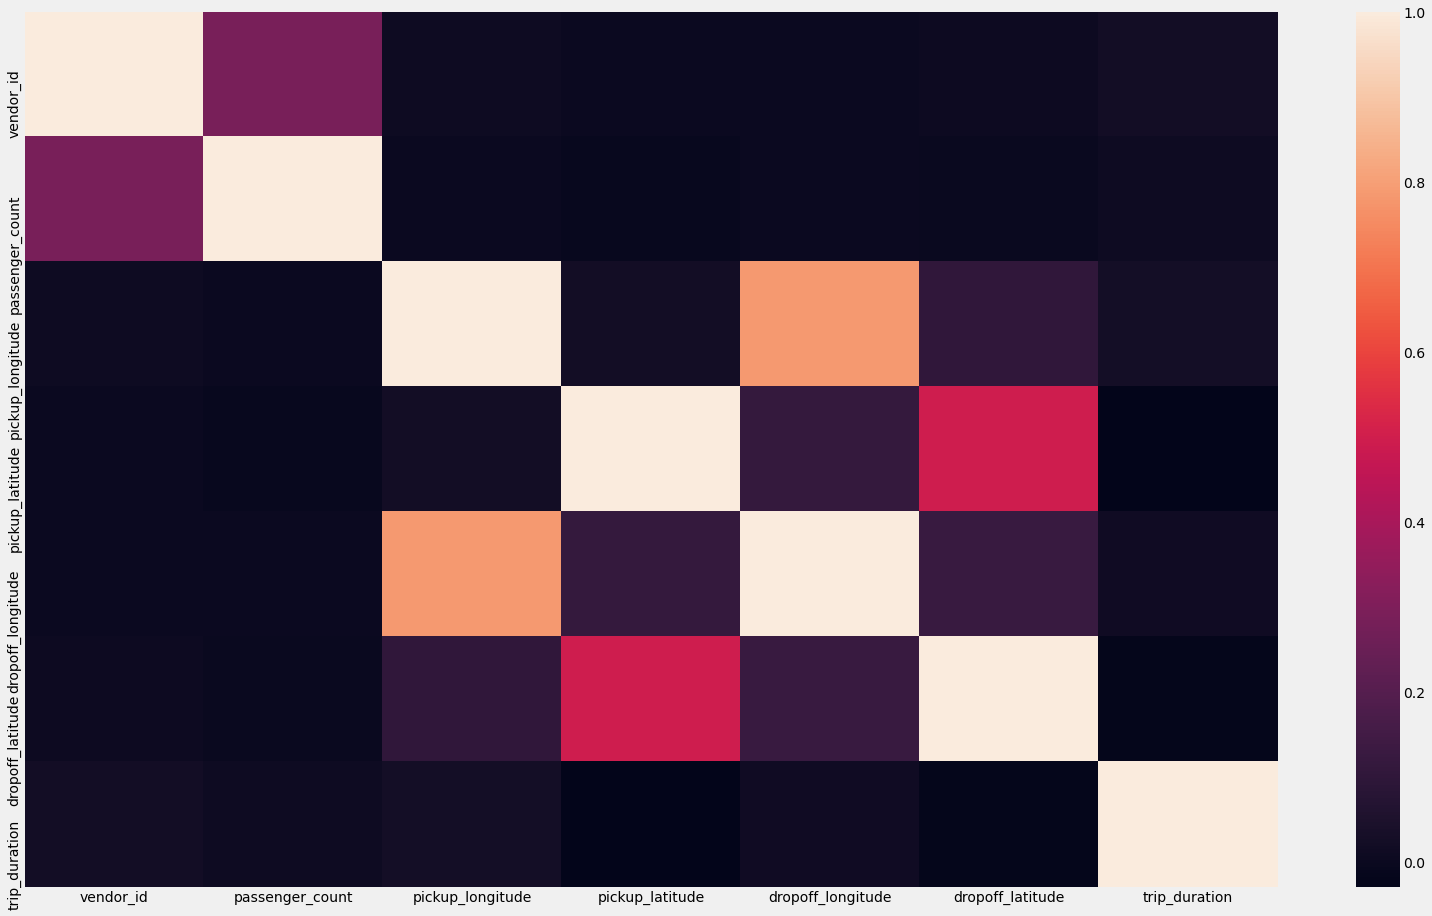

In [6]:
corr = df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()                                                                      #there is no correlation whatsoever between our dependent and independent variables, thus i will be making various features to improve this situation                                            

In [7]:
df.describe()                                                                   #their are few cases with passanger count 0, lets explore it
                                                                                #also minimum drip duretion is 1 sec which show an anomaly, lets remove them first
                                                                                # Minimum pickup and dropoff longitude are really low than mean

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
df=df[df.passenger_count!=0]                                                    #Removing rows with 0 passenger count                                      

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')                 #Converting these dates to datetime format
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [10]:
print(np.percentile(df.trip_duration,0.1),
np.percentile(df.trip_duration,0.5),
np.percentile(df.trip_duration,1.5),                                            #after this the value starts to get saturated thus anything below 107 sec is mostly a outlier, now lets look for maximum value as well
np.percentile(df.trip_duration,2),
np.percentile(df.trip_duration,2.5),
np.percentile(df.trip_duration,3),
np.percentile(df.trip_duration,3.5))

7.0 51.0 107.0 122.0 135.0 146.0 156.0


In [11]:
print(np.percentile(df.trip_duration,98.5),
np.percentile(df.trip_duration,99),
np.percentile(df.trip_duration,99.5),                                           #after this the value starts to get increase suddenly thus anything above 4139 sec is mostly a outlier, lets remove these values
np.percentile(df.trip_duration,99.9))

3072.0 3440.0 4139.0 85127.41700000013


In [12]:
df=df[(df.trip_duration>=107) & (df.trip_duration<=4139)]

In [13]:
print(np.percentile(df.pickup_longitude,0.1),
      np.percentile(df.pickup_longitude,0.05),                                  #after this their is anomaly 
      np.percentile(df.pickup_longitude,0.01),                                                                  
      np.percentile(df.pickup_longitude,0.001),
      np.percentile(df.pickup_longitude,0.0001))
df=df[df.pickup_longitude>-74.017]
print(np.percentile(df.dropoff_longitude,0.1),
      np.percentile(df.dropoff_longitude,0.05),
      np.percentile(df.dropoff_longitude,0.01),                                 #after this their is anomaly                                 
      np.percentile(df.dropoff_longitude,0.001),
      np.percentile(df.dropoff_longitude,0.0001))
df=df[df.dropoff_longitude>=-74.467]

-74.01712036132812 -74.01737976074219 -74.07968558120727 -74.35324770942688 -103.73459467295076
-74.17746734619139 -74.18138921356203 -74.18852077331543 -74.46795725708009 -79.53859309568787


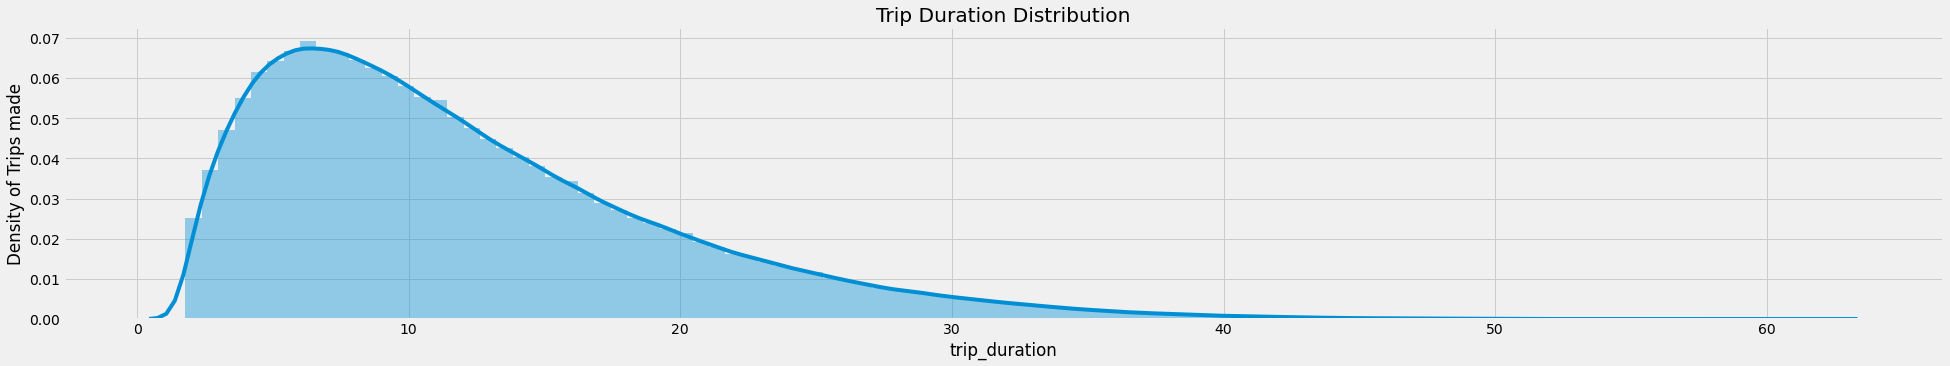

In [40]:
plt.figure(figsize=(30,5))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('Density of Trips made')
sns.distplot(df.trip_duration/60, bins=100)

In [14]:
#adding another column with distance metric calculted using lat and long 
df['haversine distance (km)'] = df.apply(lambda x: float(hs.haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']))),axis=1)
df.shape

(1427892, 12)

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()                                                                   #Data looks Perfect now,still their can be some relative anomalies, which i will remove using isolation forest                      

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine distance (km)
count,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000
mean,1.535,1.666,-73.974,40.751,-73.974,40.752,833.573,3.428
std,0.499,1.315,0.041,0.031,0.039,0.034,607.683,4.004
min,1.000,1.000,-74.017,34.360,-74.455,34.360,107.000,0.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.736,407.000,1.262
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,668.000,2.118
75%,2.000,2.000,-73.968,40.768,-73.963,40.770,1075.000,3.887
max,2.000,9.000,-61.336,51.881,-61.336,43.912,4139.000,1240.910


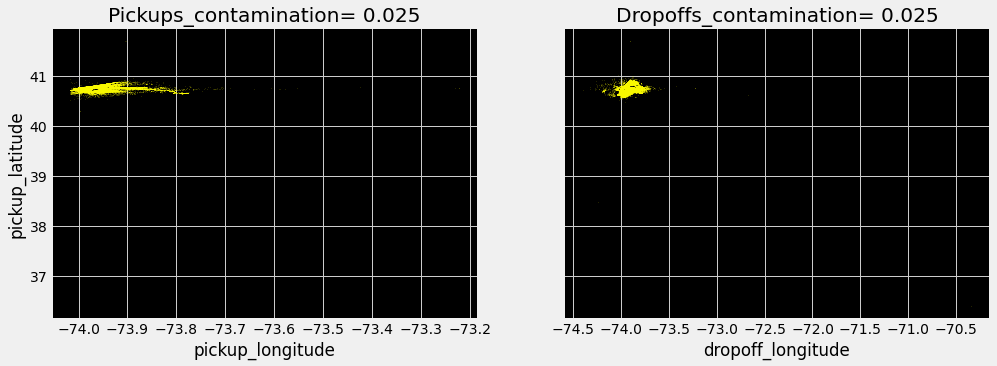

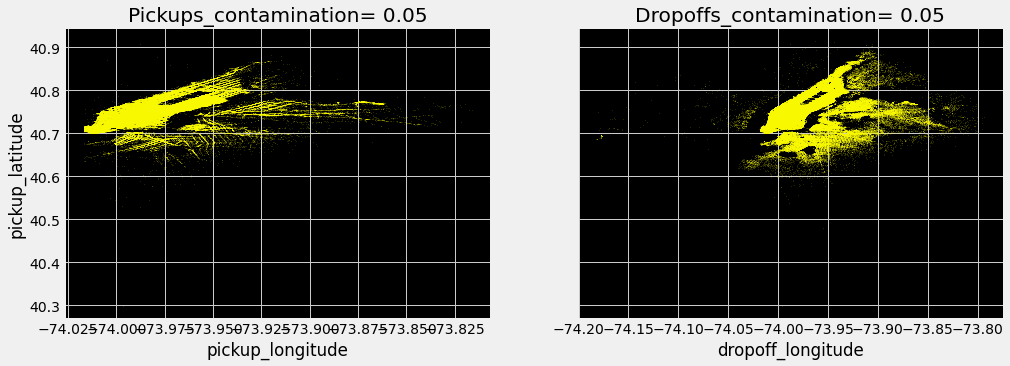

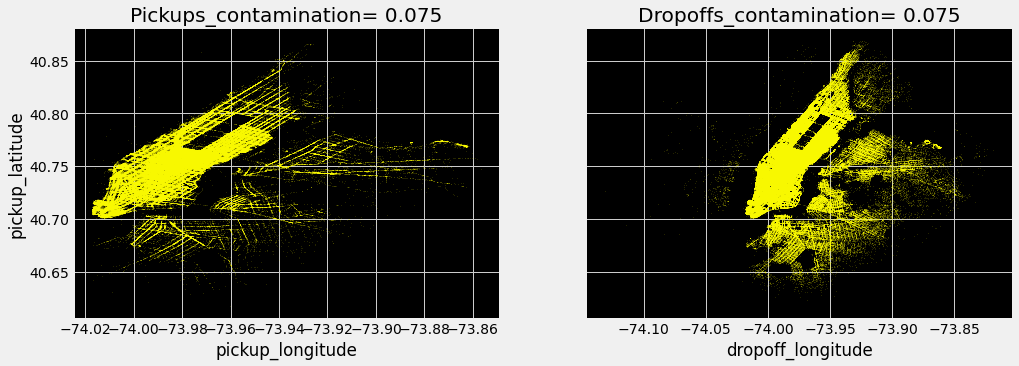

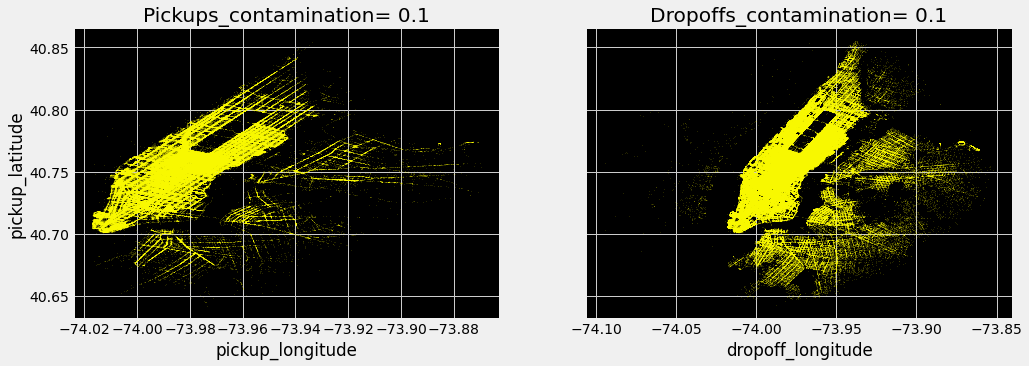

In [16]:
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
contamination_list=[0.025,0.05,0.075,0.1]
for contamination in contamination_list:
  clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)      
  try:
    clf.fit(X)
  except:
    pass
  temp=df
  temp['multivariate_outlier'] = clf.predict(X)                                   # prediction of a datapoint category outlier or inlier
  temp=temp[temp.multivariate_outlier==1]                                             #removing these outliers
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

  temp.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax1)
  ax1.set_title(f"Pickups_contamination= {contamination}")
  ax1.set_facecolor('black')

  temp.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax2)
  ax2.set_title(f"Dropoffs_contamination= {contamination}")
  ax2.set_facecolor('black') 
  plt.show()

In [15]:
'''Thus contamination=0.075 works best as we want to retain maximum amount of data'''
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
clf = IsolationForest(n_estimators=100, contamination=0.075, random_state=0)      
clf.fit(X)
df['multivariate_outlier'] = clf.predict(X)                                     # prediction of a datapoint category outlier or inlier
df=df[df.multivariate_outlier==1]  
df.drop('multivariate_outlier',axis=1,inplace=True)

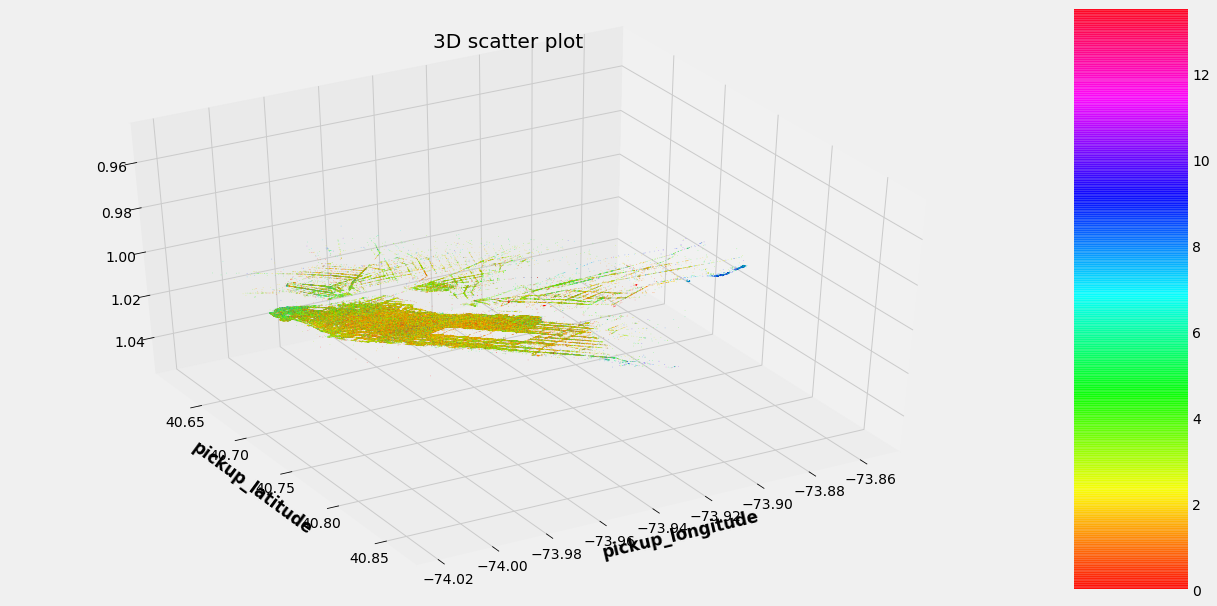

In [18]:
def plot_scatter(df):                                                           
  fig = plt.figure(figsize = (20, 10))
  ax = plt.axes(projection ="3d")
  # Creating color map
  z=range(1,len(df['pickup_longitude'])+1)
  Z=[]
  count=0
  my_cmap = plt.get_cmap('hsv')
  plot=ax.scatter3D(df['pickup_longitude'],df['pickup_latitude'],1,cmap = my_cmap,alpha = 0.8,c =df['haversine distance (km)'],s=0.02) 
  plt.title("3D scatter plot")
  ax.set_xlabel('pickup_longitude', fontweight ='bold')
  ax.set_ylabel('pickup_latitude', fontweight ='bold')
  fig.colorbar(plot, ax = ax, aspect = 5)
  ax.view_init(-140, -60)
  plt.show()       
                                                                              
plot_scatter(df)   

In [33]:
import folium
from folium import plugins
from folium.plugins import HeatMap

map_NY = folium.Map(location=[40.767937,-73.982155 ],
                    zoom_start = 13) 
heat_df = df[:20000]
heat_df = heat_df[['pickup_latitude', 'pickup_longitude']]
heat_df = heat_df.dropna(axis=0, subset=['pickup_latitude', 'pickup_longitude'])
heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in heat_df.iterrows()] # List comprehension to make out list of lists

HeatMap(heat_data).add_to(map_NY)                                                                    # Plot it on the map

map_NY

In [19]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.499
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.806
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.385
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.486
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.189


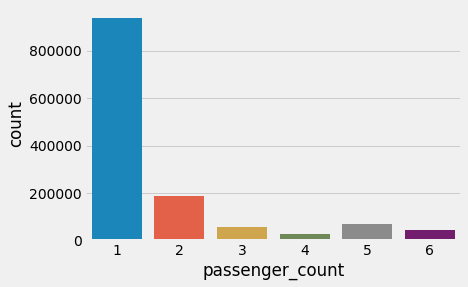

In [16]:
try:
  df.drop('id',axis=1,inplace=True)                                             #this is of no use
except:
  pass
sns.countplot(df.passenger_count)

In [17]:
one_hot_entity='Passenger_count'    
column_one_hot=['passenger_count']                # one hot encoding 
count=0
for i in column_one_hot:
  temp_df=pd.get_dummies(df[i], prefix=one_hot_entity)
  count+=1
  try:
    df_one_hot=pd.concat([df_one_hot, temp_df], axis=1)
  except:
    df_one_hot=temp_df
df=pd.concat([df,df_one_hot], axis=1)
df.drop('passenger_count',axis=1,inplace=True)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km),Passenger_count_1,Passenger_count_2,Passenger_count_3,Passenger_count_4,Passenger_count_5,Passenger_count_6
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,1,0,0,0,0,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,1,0,0,0,0,0
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385107,1,0,0,0,0,0
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500,1,0,0,0,0,0
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,1,0,0,0,0,0


In [18]:
list=['pickup_','dropoff_']
for i in list:  
  df[i+'date'] = df[i+'datetime'].dt.date
  df[i+'day'] = df[i+'datetime'].dt.day
  df[i+'month'] = df[i+'datetime'].dt.month
  df[i+'weekday'] = df[i+'datetime'].dt.weekday
  df[i+'weekofyear'] = df[i+'datetime'].dt.weekofyear
  df[i+'time'] = df[i+'datetime'].dt.hour

In [19]:
df['log_trip_duration']= np.log(df.trip_duration)                               #Normalizing the value of trip_duration
df['haversine distance (km)']= np.log(df['haversine distance (km)']) 
df['store_and_fwd_flag']=df.store_and_fwd_flag.apply(lambda x: np.where(x=='N',0,1))
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km),Passenger_count_1,Passenger_count_2,Passenger_count_3,Passenger_count_4,Passenger_count_5,Passenger_count_6,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,dropoff_date,dropoff_day,dropoff_month,dropoff_weekday,dropoff_weekofyear,dropoff_time,log_trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,0,455,0.404480,1,0,0,0,0,0,2016-03-14,14,3,0,11,17,2016-03-14,14,3,0,11,17,6.120297
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,0,663,0.590843,1,0,0,0,0,0,2016-06-12,12,6,6,23,0,2016-06-12,12,6,6,23,0,6.496775
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,0,2124,1.853968,1,0,0,0,0,0,2016-01-19,19,1,1,3,11,2016-01-19,19,1,1,3,12,7.661056
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,0,429,0.395752,1,0,0,0,0,0,2016-04-06,6,4,2,14,19,2016-04-06,6,4,2,14,19,6.061457
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,0,435,0.172768,1,0,0,0,0,0,2016-03-26,26,3,5,12,13,2016-03-26,26,3,5,12,13,6.075346


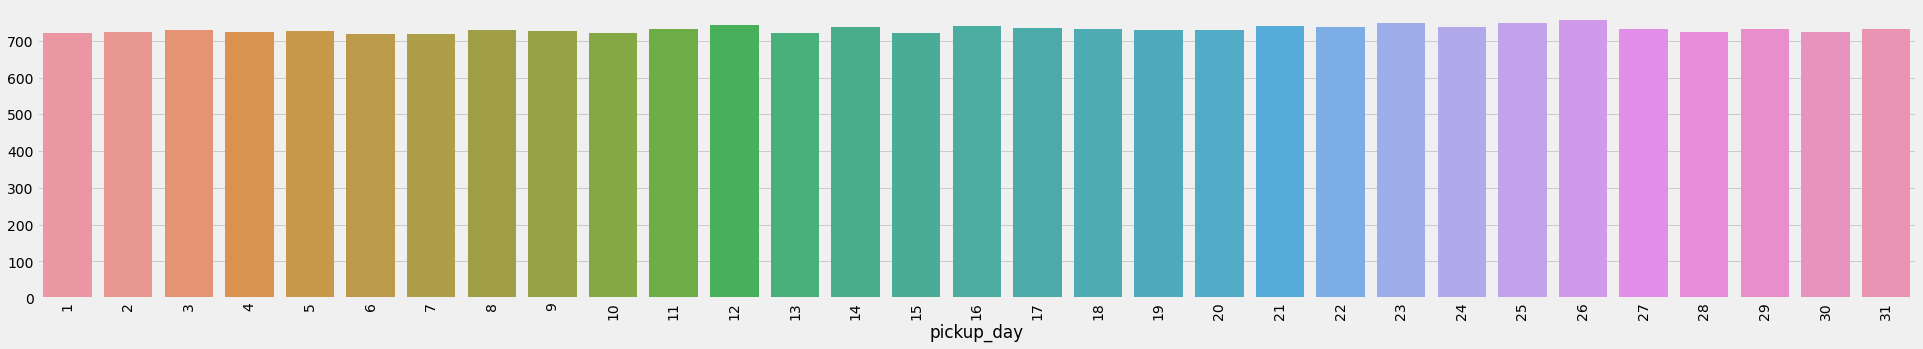

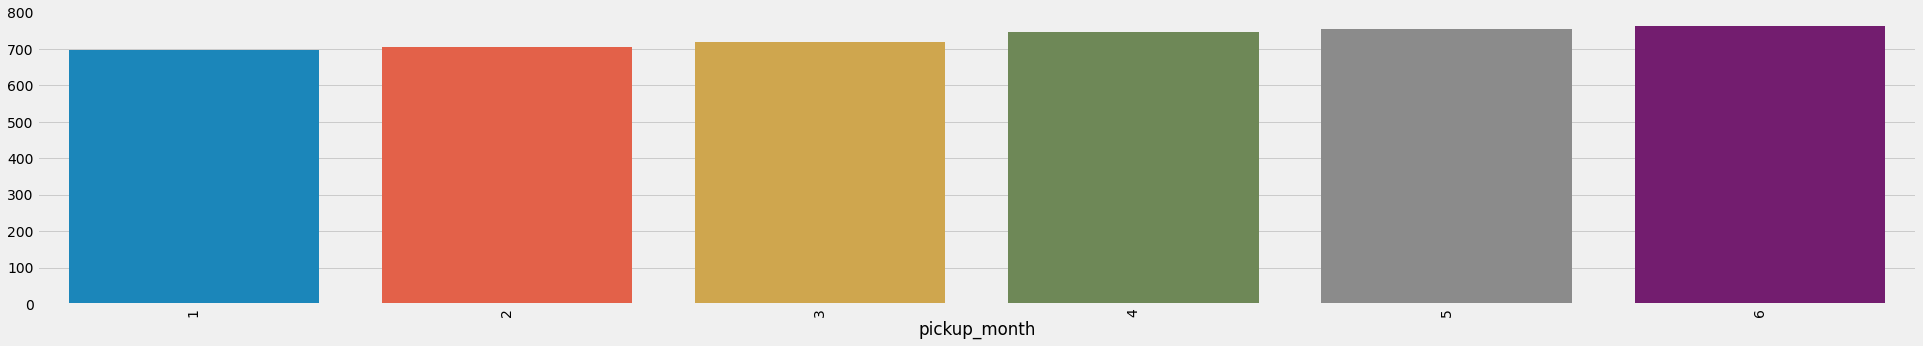

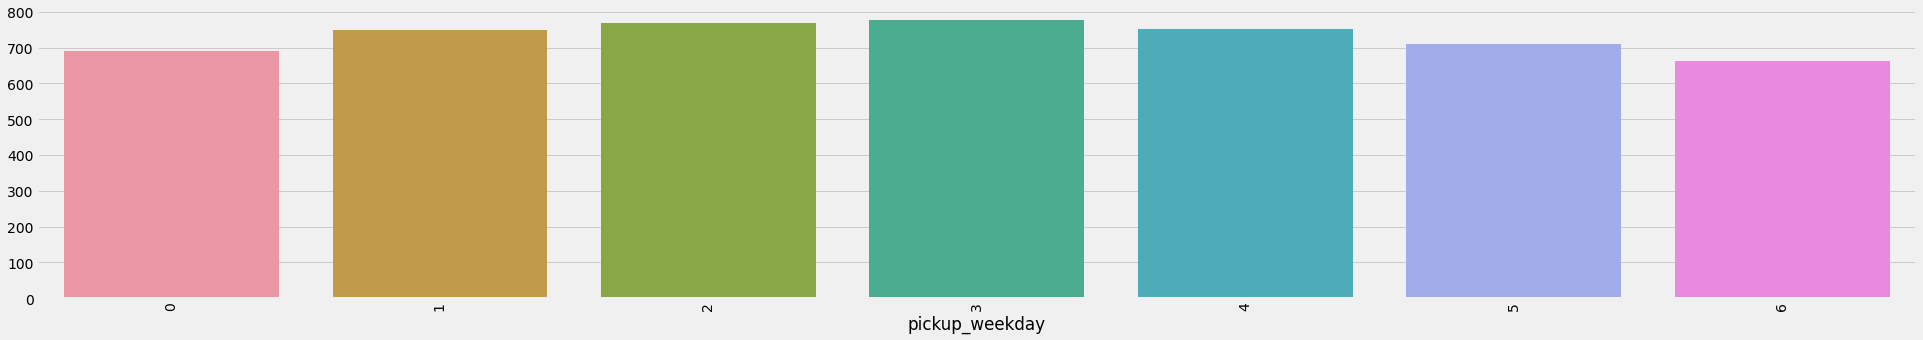

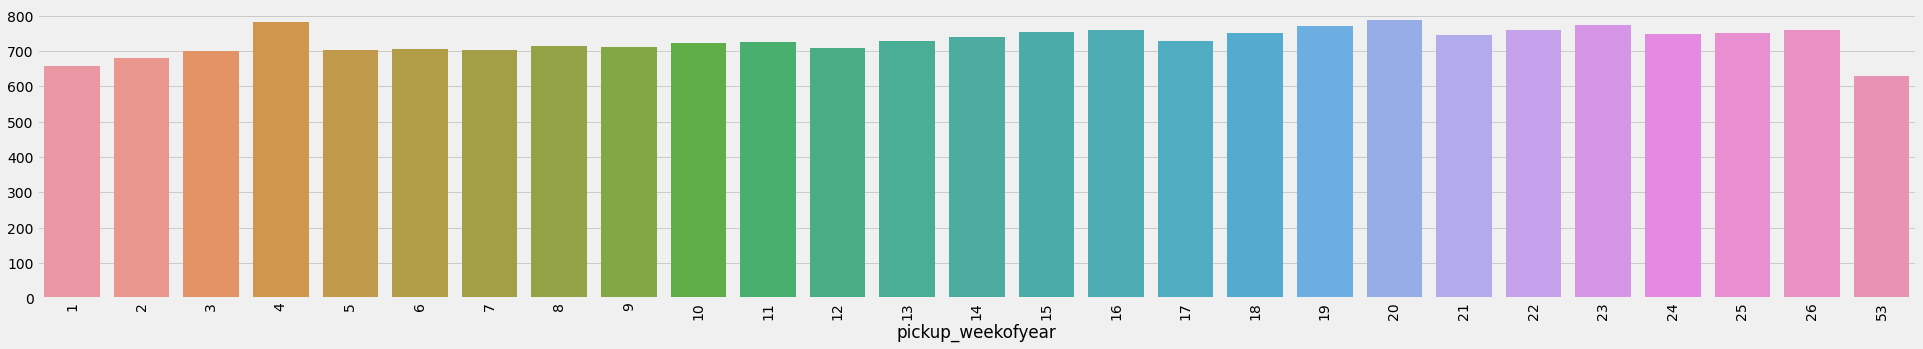

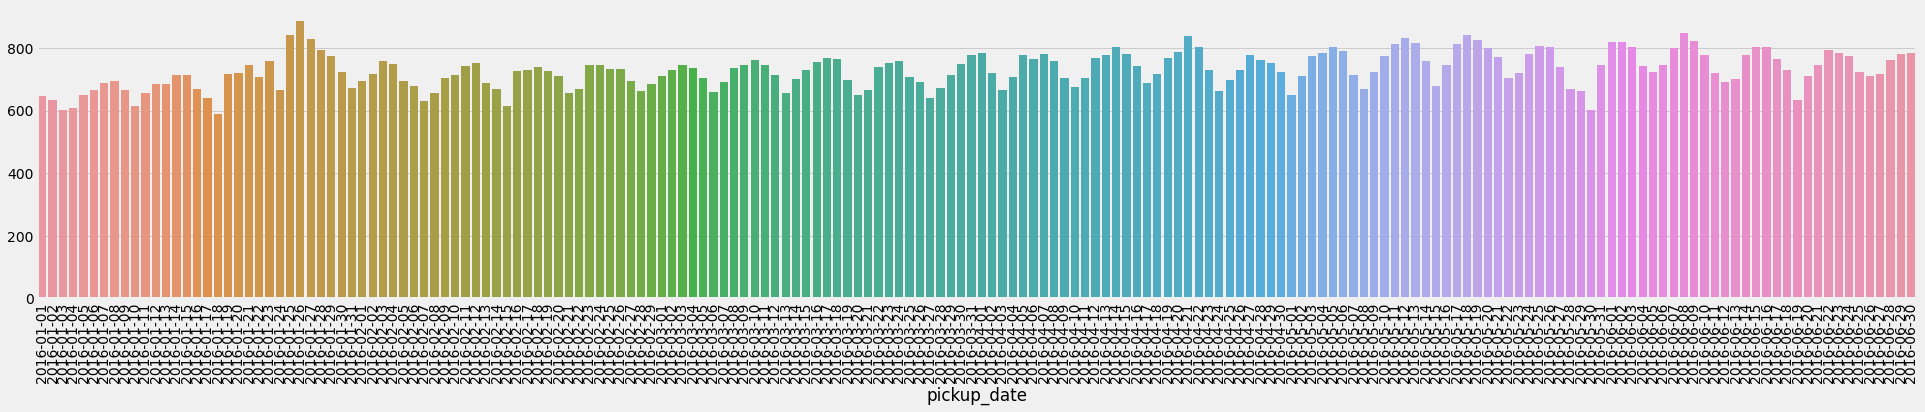

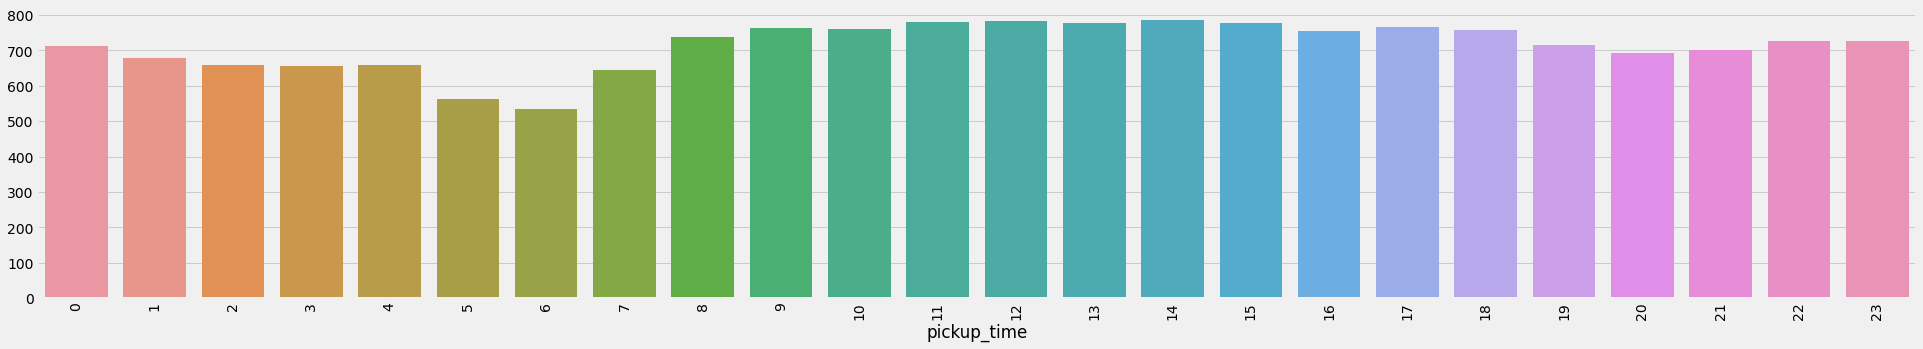

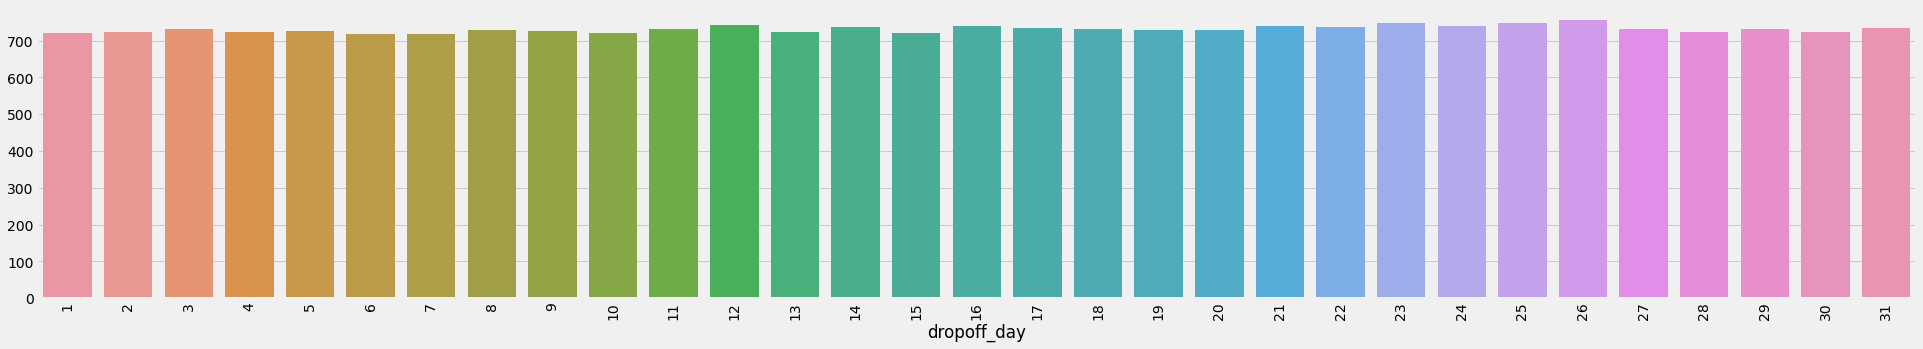

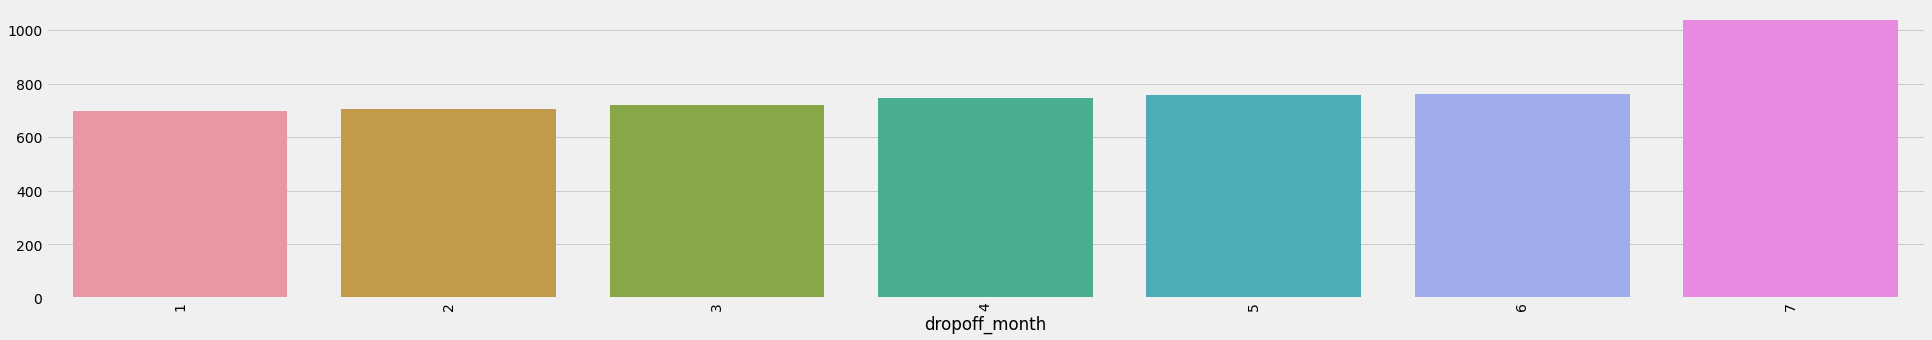

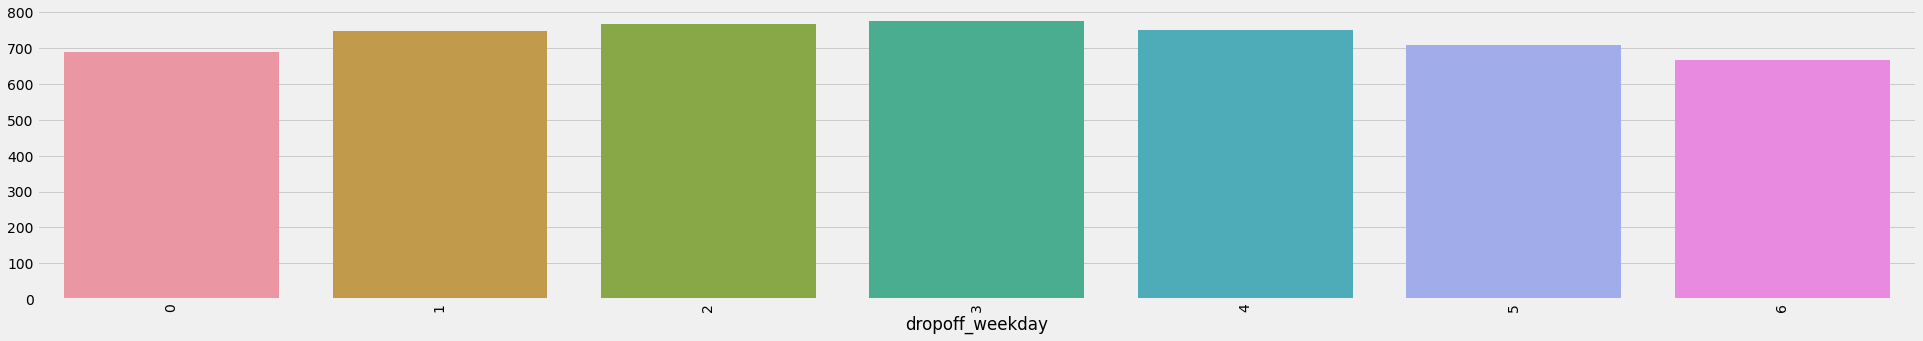

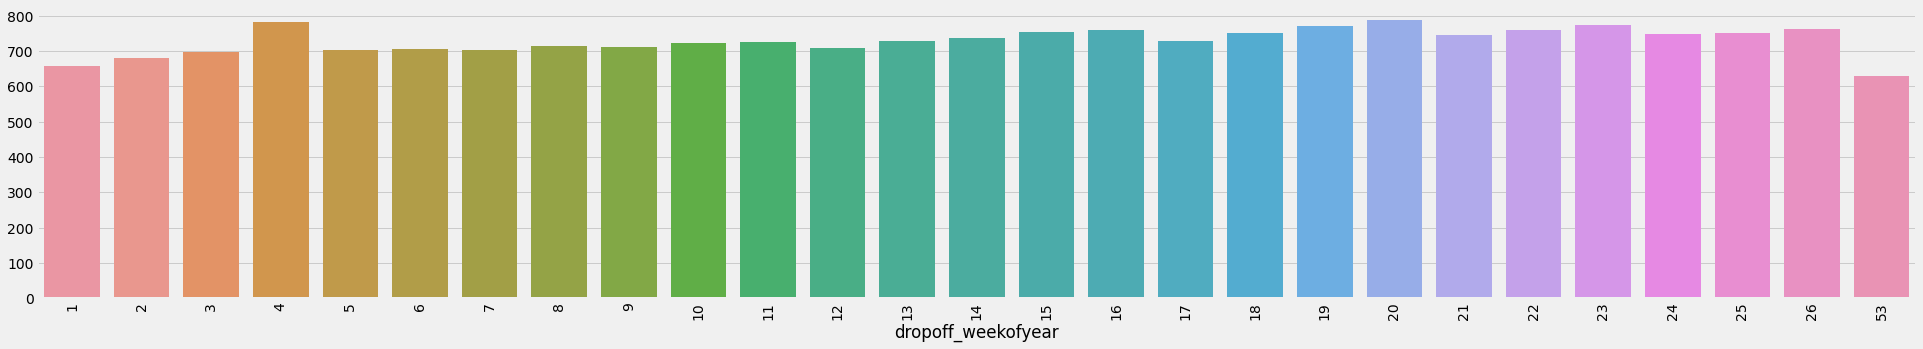

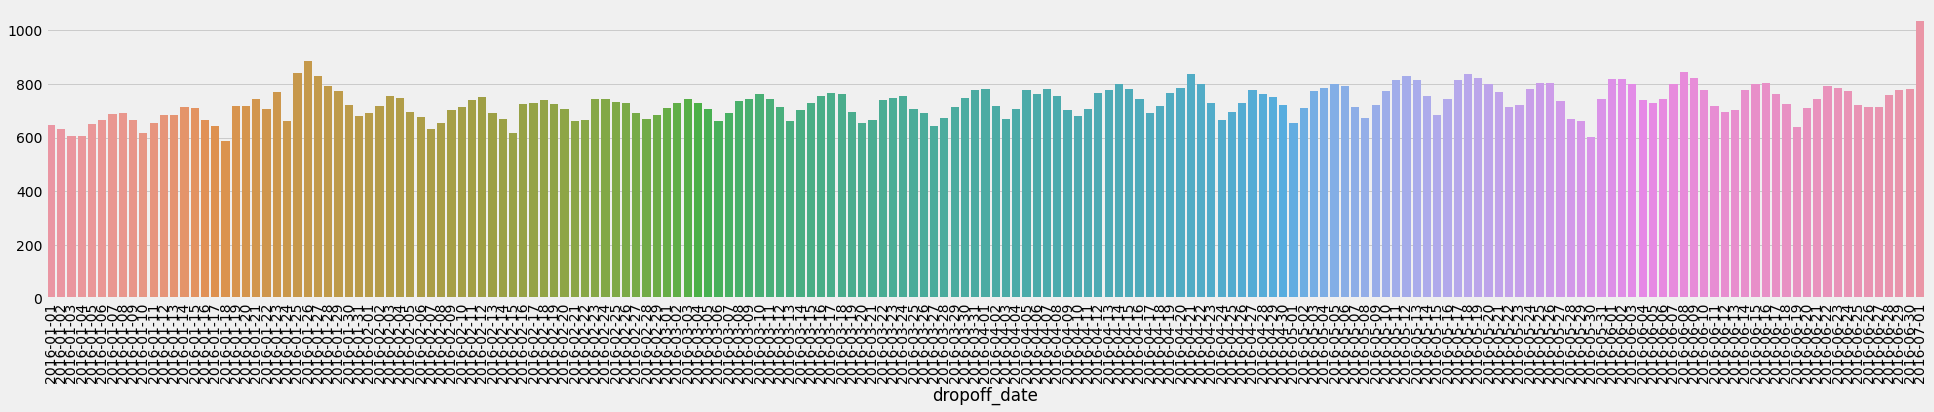

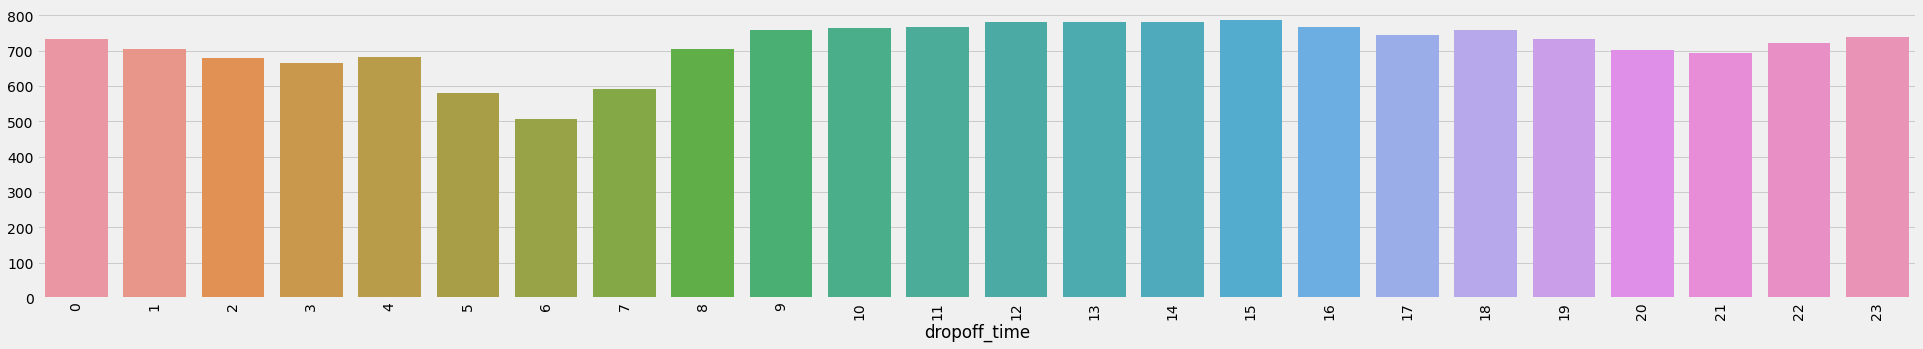

In [44]:
list1=['day','month','weekday','weekofyear','date','time']
list2=['pickup_','dropoff_']
for i in list2:
  for j in list1:
    plt.figure(figsize=(30,5))
    temp=df.groupby(i+j)['trip_duration'].mean()
    sns.barplot(temp.index,temp.values)
    plt.xticks(rotation=90)
    plt.show()                                                                  # for all the time criteria trip durations are almost the same, except that of hours in a day, lets plot autocorelation chart to look for seasonality.

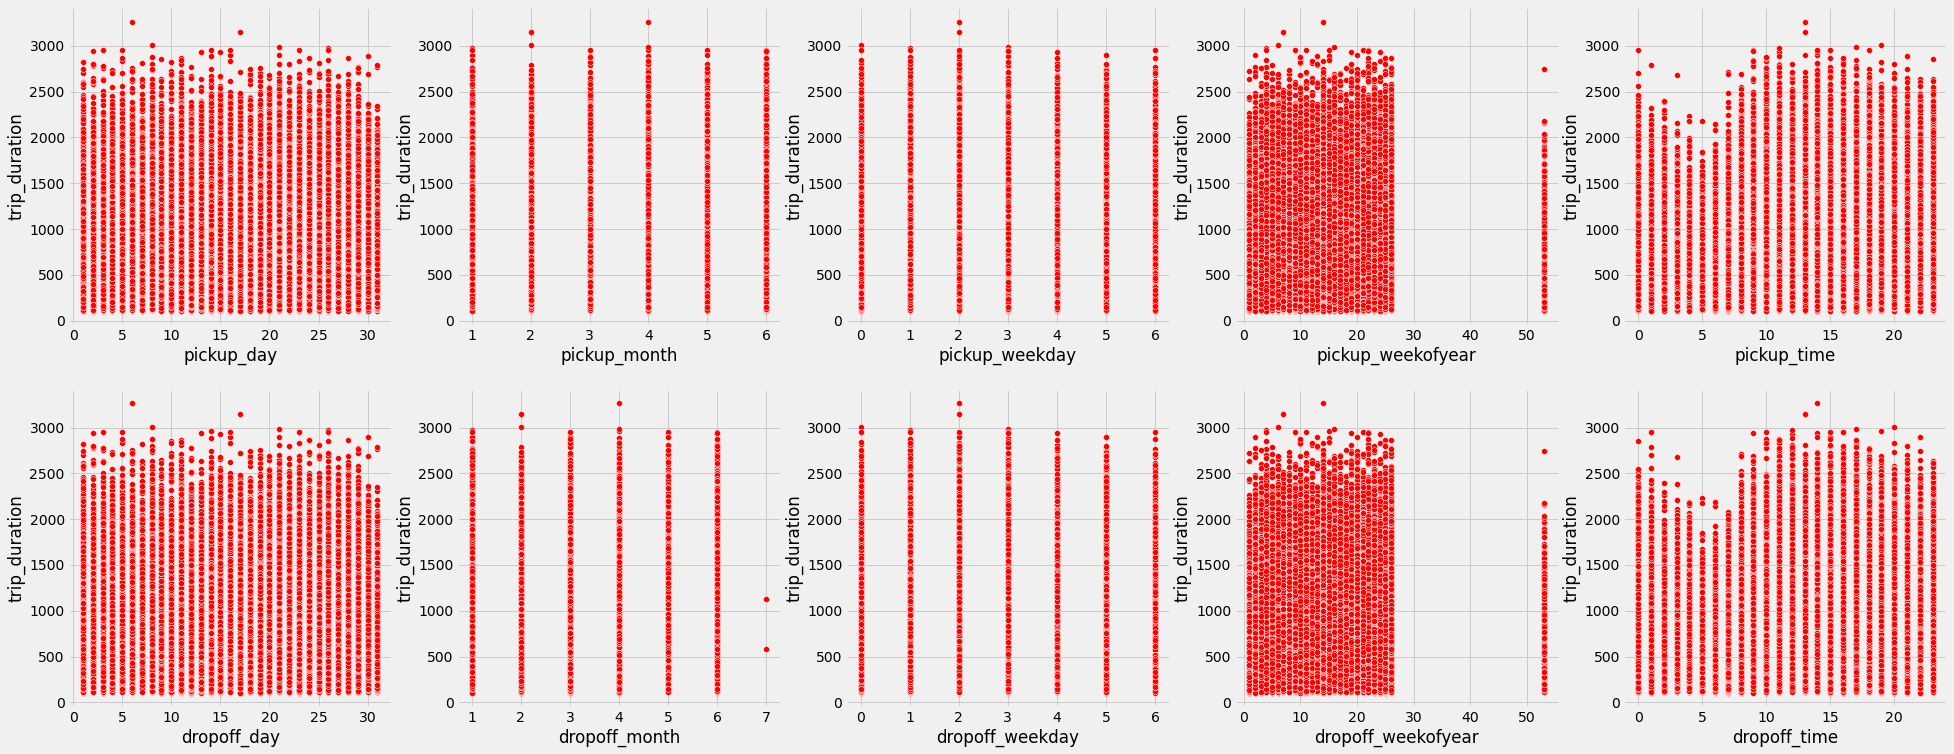

In [25]:
time_attribute=['day','month','weekday','weekofyear','time']
service_nature=['pickup_','dropoff_']
count=0
counter=0
fig,ax=plt.subplots(2,5,figsize=(30,12))
plt.rcParams['axes.facecolor'] = 'black'
for service in service_nature:
  if counter==5:
    count=1
    counter=0
  for attribute in time_attribute:
    sns.scatterplot(df[service+attribute][:100000],df.trip_duration[:100000],color='red',ax=ax[count,counter])
    
    counter+=1                                                                  

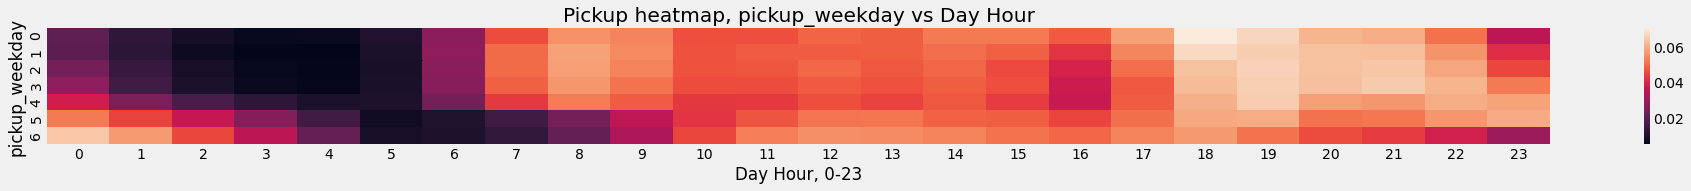

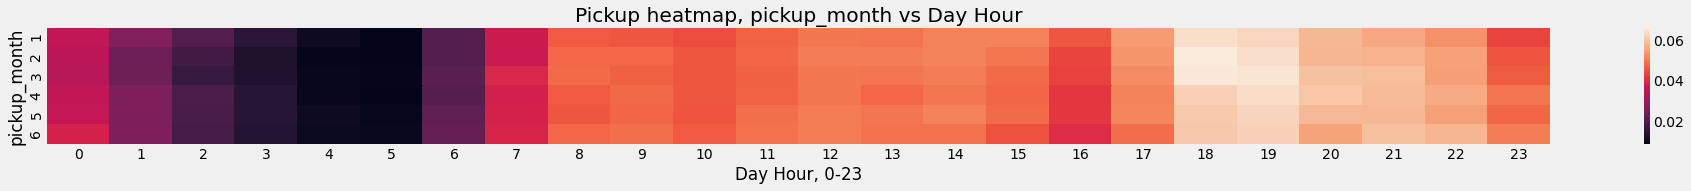

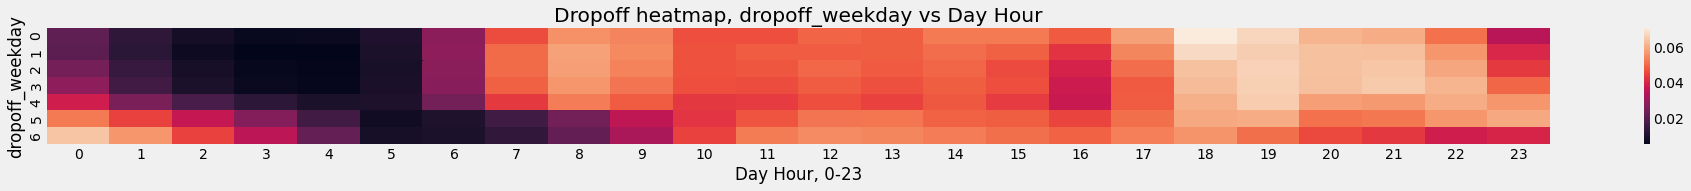

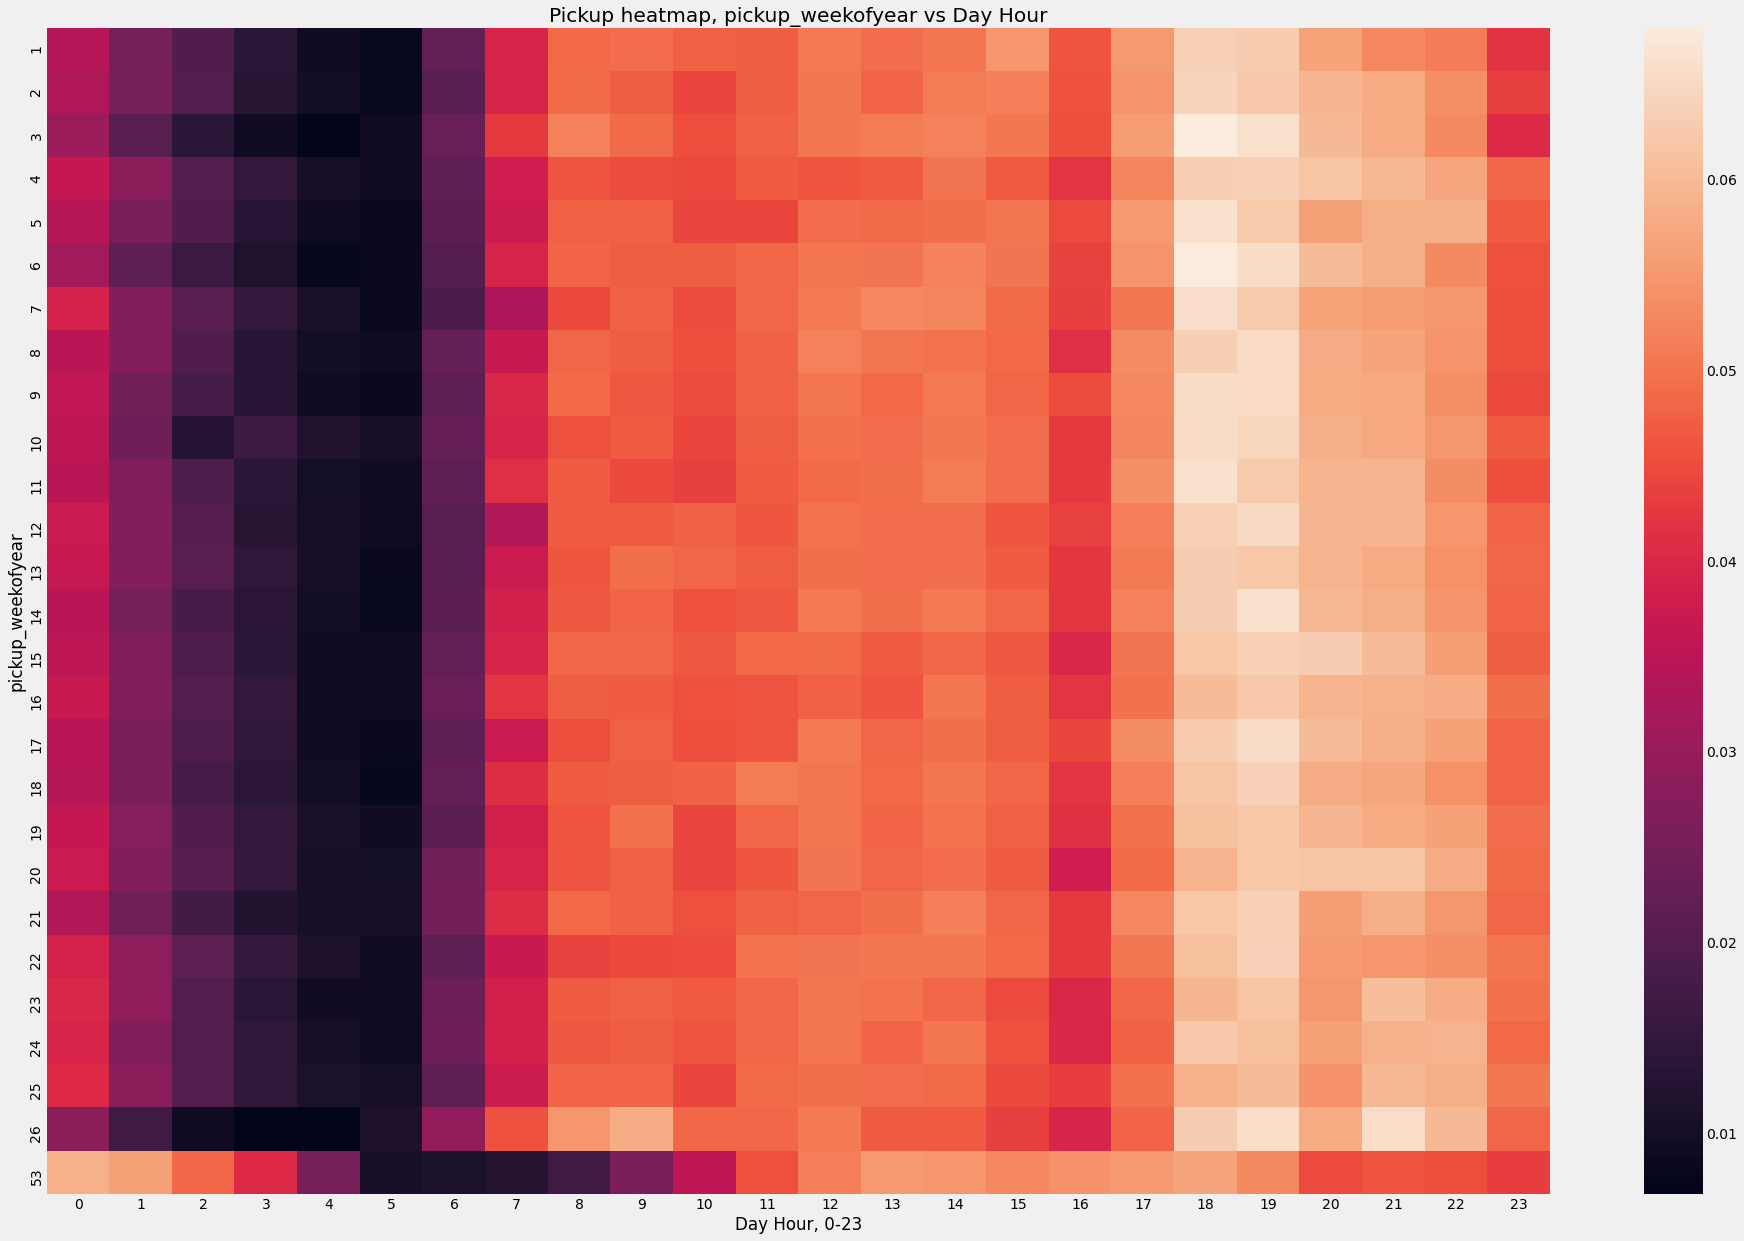

In [36]:
plot_list=['pickup_weekday','pickup_month','dropoff_weekday','pickup_weekofyear']
count=0
for i in plot_list:
  count+=1
  if count==4:
    plt.figure(figsize=(30,20))
  else:
    plt.figure(figsize=(30,2))
  sns.heatmap(data=pd.crosstab(df[i], 
                              df.pickup_time, 
                              values=df.vendor_id, 
                              aggfunc='count',
                              normalize='index'))
  if count==3:
    plt.title(f'Dropoff heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    plt.show()
  else:
    plt.title(f'Pickup heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    
    plt.show()                                                                    #Both heat maps tells the similar story, 6-7pm are the peak times, and nights hardly have any bookings.

In [45]:
df['avg_speed_h2']=df['haversine distance (km)'] / df['trip_duration'] *3600    #converting sec to hours

In [46]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km),Passenger_count_1,Passenger_count_2,Passenger_count_3,Passenger_count_4,Passenger_count_5,Passenger_count_6,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,dropoff_date,dropoff_day,dropoff_month,dropoff_weekday,dropoff_weekofyear,dropoff_time,log_trip_duration,avg_speed_h2
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,0,455,0.404480,1,0,0,0,0,0,2016-03-14,14,3,0,11,17,2016-03-14,14,3,0,11,17,6.120297,3.200280
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,0,663,0.590843,1,0,0,0,0,0,2016-06-12,12,6,6,23,0,2016-06-12,12,6,6,23,0,6.496775,3.208197
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,0,2124,1.853968,1,0,0,0,0,0,2016-01-19,19,1,1,3,11,2016-01-19,19,1,1,3,12,7.661056,3.142319
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,0,429,0.395752,1,0,0,0,0,0,2016-04-06,6,4,2,14,19,2016-04-06,6,4,2,14,19,6.061457,3.320994
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,0,435,0.172768,1,0,0,0,0,0,2016-03-26,26,3,5,12,13,2016-03-26,26,3,5,12,13,6.075346,1.429803


In [47]:
df.drop(['pickup_datetime','dropoff_datetime','trip_duration','pickup_date','dropoff_date','dropoff_day','dropoff_month','dropoff_weekday','dropoff_weekofyear','dropoff_time'],axis=1,inplace=True)

In [48]:
df['lat_diff']=df.dropoff_latitude-df.pickup_latitude
df['long_diff']=df.dropoff_longitude-df.pickup_longitude                        # west yeild -ve on long_diff, vice versa & north yeild + lat_diff and vice versa, thus we can now give directions.
# df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [49]:
df['North']=df['lat_diff'].apply(lambda x: np.where(x>0,1,0))
df['South']=df['lat_diff'].apply(lambda x: np.where(x<0,1,0))
df['West']=df['long_diff'].apply(lambda x: np.where(x<0,1,0))
df['East']=df['long_diff'].apply(lambda x: np.where(x>0,1,0))

df.head()

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine distance (km),Passenger_count_1,Passenger_count_2,Passenger_count_3,Passenger_count_4,Passenger_count_5,Passenger_count_6,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,log_trip_duration,avg_speed_h2,lat_diff,long_diff,North,South,West,East
0,2,-73.982155,40.767937,-73.964630,40.765602,0,0.404480,1,0,0,0,0,0,14,3,0,11,17,6.120297,3.200280,-0.002335,0.017525,0,1,0,1
1,1,-73.980415,40.738564,-73.999481,40.731152,0,0.590843,1,0,0,0,0,0,12,6,6,23,0,6.496775,3.208197,-0.007412,-0.019066,0,1,1,0
2,2,-73.979027,40.763939,-74.005333,40.710087,0,1.853968,1,0,0,0,0,0,19,1,1,3,11,7.661056,3.142319,-0.053852,-0.026306,0,1,1,0
3,2,-74.010040,40.719971,-74.012268,40.706718,0,0.395752,1,0,0,0,0,0,6,4,2,14,19,6.061457,3.320994,-0.013252,-0.002228,0,1,1,0
4,2,-73.973053,40.793209,-73.972923,40.782520,0,0.172768,1,0,0,0,0,0,26,3,5,12,13,6.075346,1.429803,-0.010689,0.000130,0,1,0,1


In [50]:
column_one_hot=['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id']                # one hot encoding 
for i in column_one_hot:
  temp2_df=pd.get_dummies(df[i], prefix=i)
  try:
    df_one_hot2=pd.concat([df_one_hot2, temp2_df], axis=1)
  except:
    df_one_hot2=temp2_df

In [51]:
df=pd.concat([df,df_one_hot2], axis=1)
df.drop(['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','lat_diff','long_diff'],axis=1,inplace=True)

In [52]:
df.head()

,store_and_fwd_flag,haversine distance (km),Passenger_count_1,Passenger_count_2,Passenger_count_3,Passenger_count_4,Passenger_count_5,Passenger_count_6,log_trip_duration,avg_speed_h2,North,South,West,East,pickup_time_0,pickup_time_1,pickup_time_2,pickup_time_3,pickup_time_4,pickup_time_5,pickup_time_6,pickup_time_7,pickup_time_8,pickup_time_9,pickup_time_10,pickup_time_11,pickup_time_12,pickup_time_13,pickup_time_14,pickup_time_15,pickup_time_16,pickup_time_17,pickup_time_18,pickup_time_19,pickup_time_20,pickup_time_21,pickup_time_22,pickup_time_23,pickup_weekofyear_1,pickup_weekofyear_2,...,pickup_weekday_6,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,pickup_day_1,pickup_day_2,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,pickup_day_7,pickup_day_8,pickup_day_9,pickup_day_10,pickup_day_11,pickup_day_12,pickup_day_13,pickup_day_14,pickup_day_15,pickup_day_16,pickup_day_17,pickup_day_18,pickup_day_19,pickup_day_20,pickup_day_21,pickup_day_22,pickup_day_23,pickup_day_24,pickup_day_25,pickup_day_26,pickup_day_27,pickup_day_28,pickup_day_29,pickup_day_30,pickup_day_31,vendor_id_1,vendor_id_2
0,0,0.404480,1,0,0,0,0,0,6.120297,3.200280,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0.590843,1,0,0,0,0,0,6.496775,3.208197,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1.853968,1,0,0,0,0,0,7.661056,3.142319,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0.395752,1,0,0,0,0,0,6.061457,3.320994,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0.172768,1,0,0,0,0,0,6.075346,1.429803,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


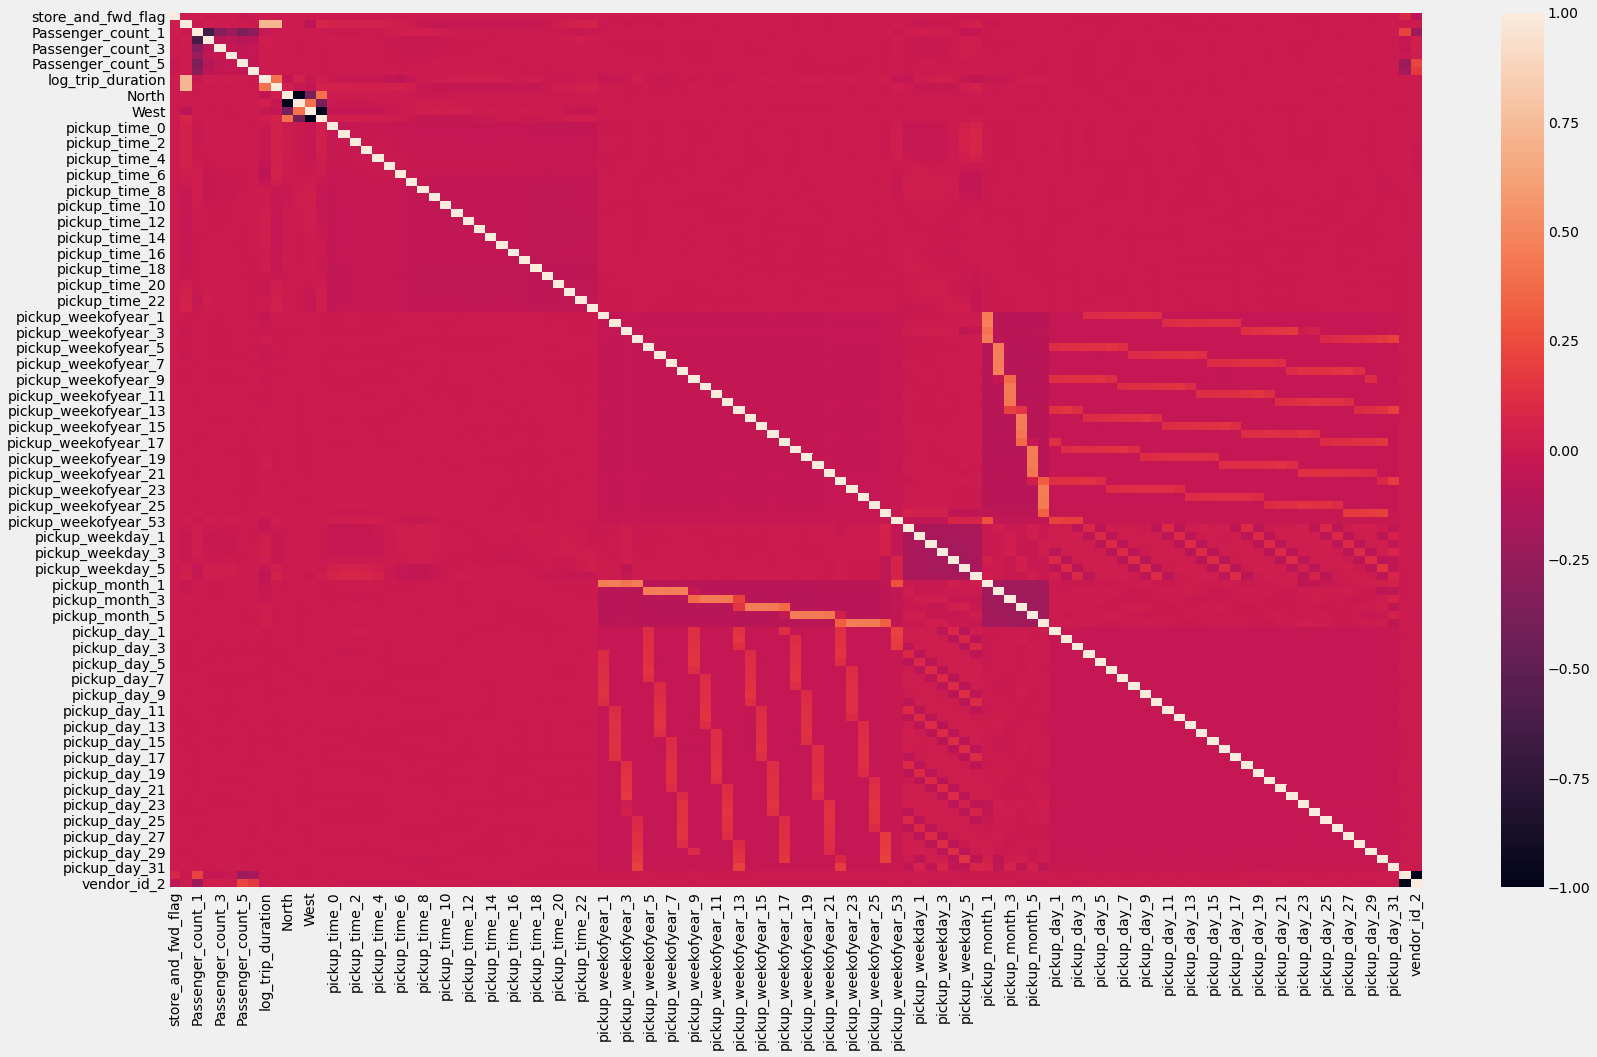

In [34]:
corr =df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()   

In [147]:
X=df.drop('log_trip_duration',axis=1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.05)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.05)

In [48]:
model = XGBRegressor()                                                          # base model 
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(r2_score(y_test,y_pred_test))
print('RMSE score for the XGboost is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
print(r2_score(y_train,y_pred_train))
print('RMSE score for the XGboost is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))) #their is no over fitting thus we can train out model to a greater depth and possibly get a better result.
#wow accuracy of 90%, lets do hyper-parameter tuning to get better results

[09:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9073377935399715
RMSE score for the CatRegressor is : 0.19494558787516533
0.9090712406641592
RMSE score for the CatRegressor is : 0.19213501069160963


As, Dataset is quite huge, using Kfold Cross-Validation and gridsearch was impossible due to hardware constraints, thus i decided to change values on by own by running model and looking at result multiple times.

In [72]:
model = XGBRegressor(max_depth=10,                                             
                     learning_rate=0.08,
                     verbosity=0,
                     objective='reg:squarederror')                                                         
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(r2_score(y_test,y_pred_test))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
print(r2_score(y_train,y_pred_train))
print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))))
#Wow 97% r2 Score

0.9779694022367151
RMSE score for the CatRegressor is : 0.0944408550976006
0.9790906061176234
RMSE score for the CatRegressor is : 0.09217554368737493


this was the best accuracy i was able to achieve using XGBoost model, after switching various Hyperparameters.

In [82]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)  #Sort the DataFrame in order decreasing feature importance
    plt.figure(figsize=(30,8))
    sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.xticks(rotation=90)
    plt.ylabel('FEATURE NAMES')

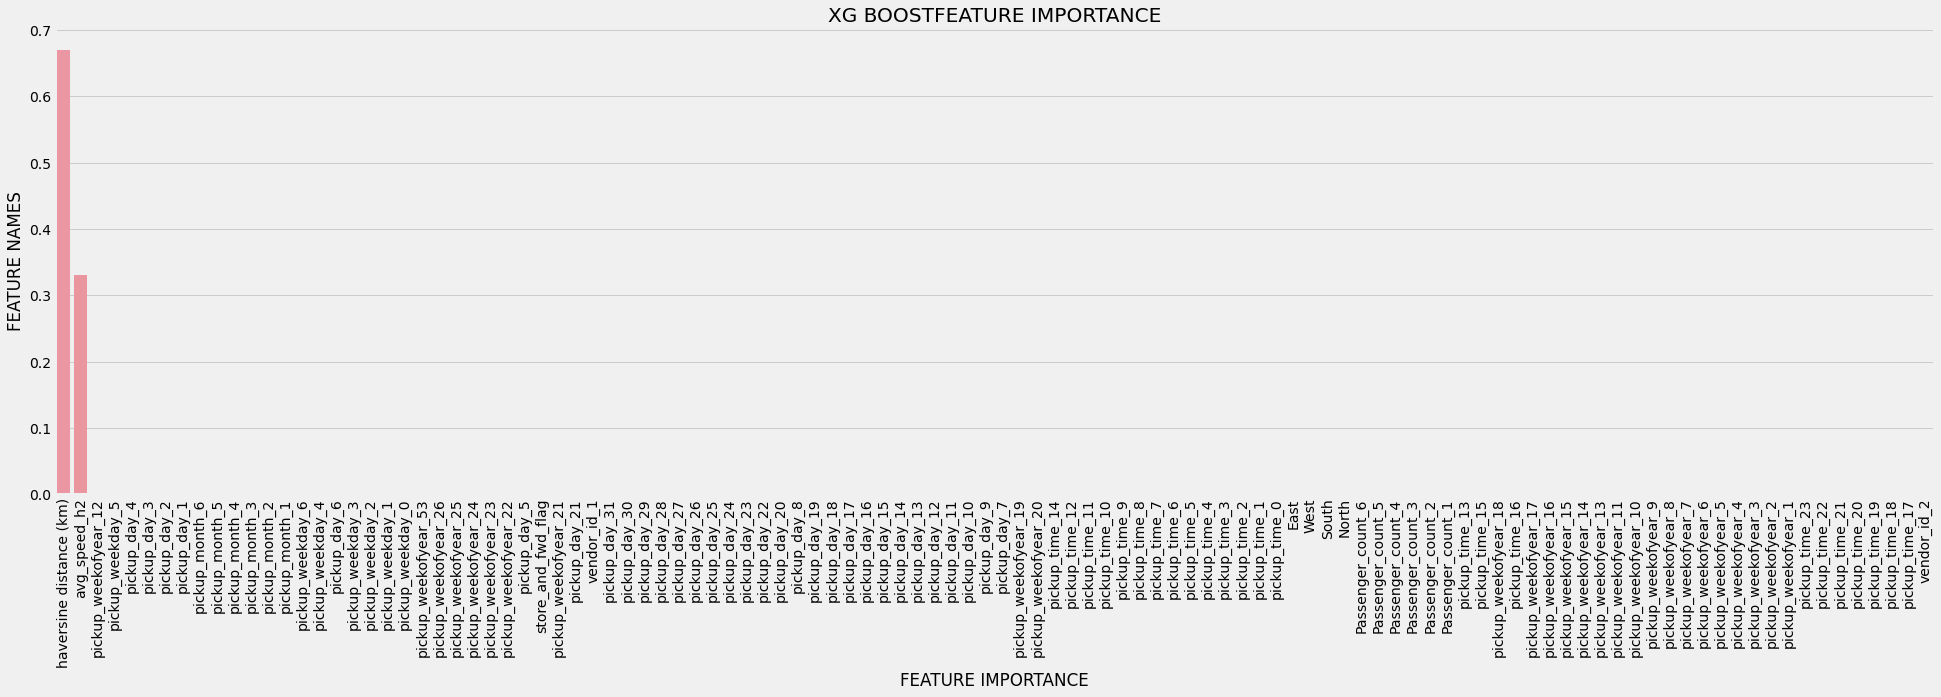

In [83]:
plot_feature_importance(model.feature_importances_,X_train.columns,'XG BOOST')#Plotting Feature Importance for XGboost

#Cat Boost Model

In [85]:
cat_model = CatBoostRegressor(loss_function = "RMSE", eval_metric = "RMSE", metric_period = 100, iterations=1000,
                        use_best_model = True,
                        random_strength = 0.5,
                        learning_rate=0.5,
                        depth=10,
                        random_seed = 93,
                        l2_leaf_reg = 0.1,
                        verbose=True,
                        logging_level = None,od_type = "Iter",
                        od_wait = 200)
cat_model.fit( X_train, y_train, cat_features=None, eval_set=(X_val,y_val))
   

0:	learn: 0.4070743	test: 0.4062522	best: 0.4062522 (0)	total: 464ms	remaining: 7m 43s
100:	learn: 0.0602442	test: 0.0602926	best: 0.0602926 (100)	total: 32.4s	remaining: 4m 48s
200:	learn: 0.0564028	test: 0.0614734	best: 0.0600779 (132)	total: 1m 5s	remaining: 4m 19s
300:	learn: 0.0531271	test: 0.0626245	best: 0.0600779 (132)	total: 1m 38s	remaining: 3m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.06007792679
bestIteration = 132

Shrink model to first 133 iterations.


In [86]:
y_pred_test_cat=cat_model.predict(X_test)
y_pred_train_cat=cat_model.predict(X_train)
print(f'r2 score for test set using  CatRegressor is : {r2_score(y_test,y_pred_test_cat)}')
print('RMSE score for test set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test_cat))))
print(f'r2 score for train set using CatRegressor is : {r2_score(y_train,y_pred_train_cat)}')
print('RMSE score for train set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train_cat))))    #Wow our model have a great r2 score of 99%         

r2 score for test set using  CatRegressor is : 0.9904380950964818
RMSE score for test set using CatRegressor is : 0.06221842027341187
r2 score for train set using CatRegressor is : 0.9915334600576444
RMSE score for train set using CatRegressor is : 0.05865404483752202


this model is not only fast but much more accurate as well.

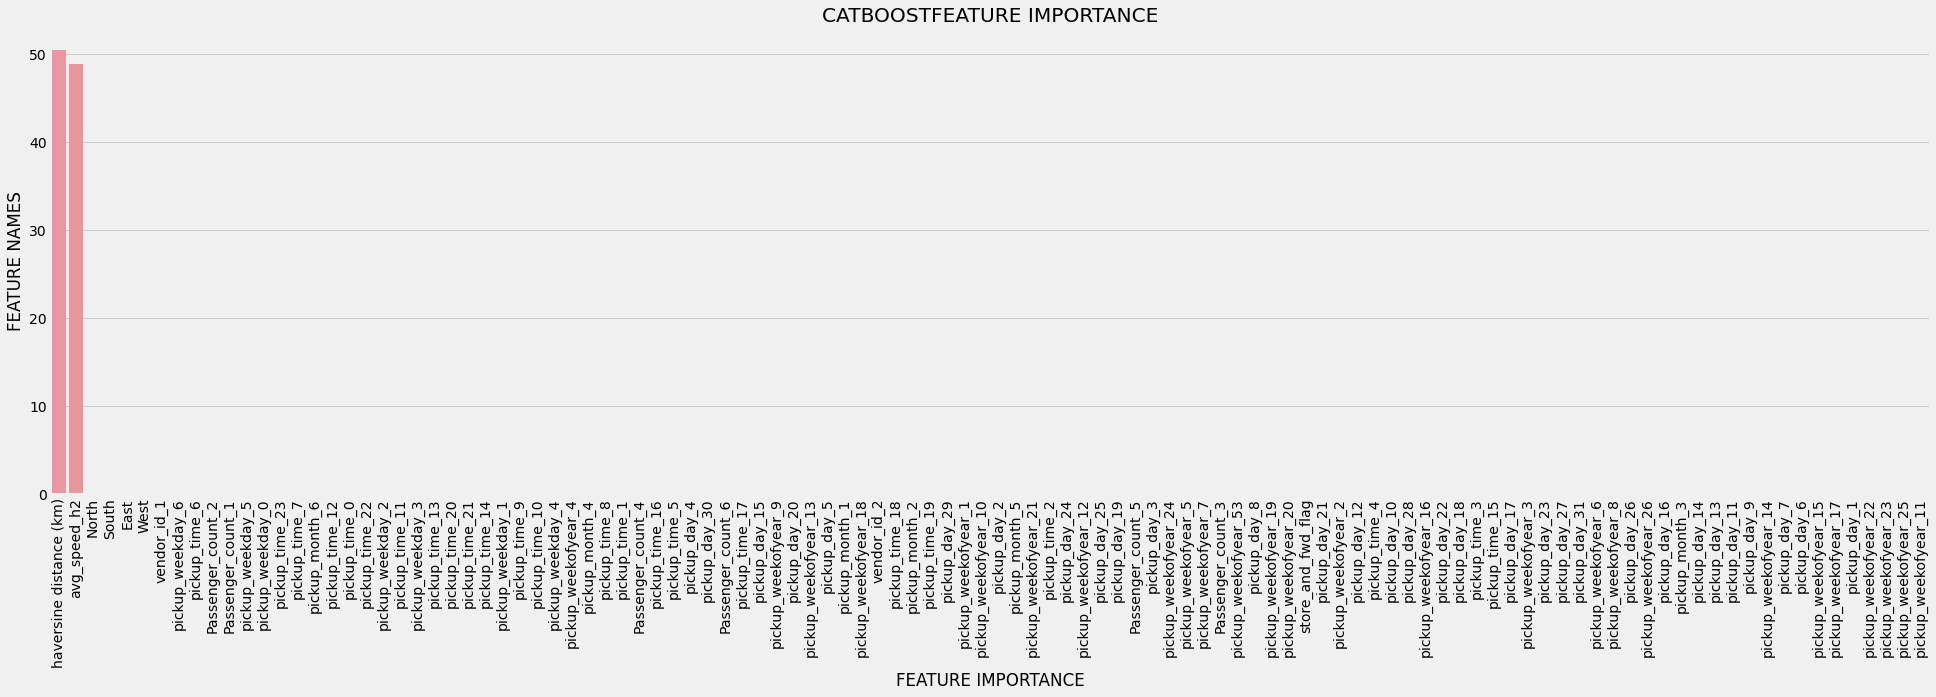

In [87]:
plot_feature_importance(cat_model.get_feature_importance(),X_train.columns,'CATBOOST') #Plotting Feature Importance for CatBoost Model

Both these feature importance plots shows that trip duration is only determined on 2 Features
1.  Distance (Km)
2.  Avg_speed
though, it should be noted that Avg Speed itself takes various time factors into mind

we can use Random Forest so as to involve other features as well, but i dont think it is necessary to use it, as we are able to fetch really good accuracy using only 2 features, involvment of other features would inturn reduce the r2Score.